In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import dvu
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import os.path
from tqdm import tqdm
import pathlib
import imodelsx.llm
import json
import requests
import numpy as np
import openai
import pubmed
import paper_parsing
import prompts
openai.api_key = open('/home/chansingh/.OPENAI_KEY').read().strip()
plt.style.use('default')
dvu.set_style()

In [2]:
df = pd.read_csv('../data/main.csv')

### Look at gender ratios

In [3]:
idxs = (df['num_male_corrected'].notnull() & ~(df['num_male_corrected'] == 'Unk')) & (df['num_female_corrected'].notnull() & ~(df['num_female_corrected'] == 'Unk'))
male = df['num_male_corrected'][idxs].astype(int)
female = df['num_female_corrected'][idxs].astype(int)

In [4]:
ratios = (male / female).values
# drop inf
print(sorted(ratios))

[0.0, 0.0, 0.14014251781472684, 0.2193158953722334, 0.2647058823529412, 0.2787716579799972, 0.33684794672586016, 0.48488180318856516, 0.6142857142857143, 0.6239465271723337, 0.6404109589041096, 0.6948228882833788, 0.7421619092185306, 0.7525252525252525, 0.7727272727272727, 0.8007149240393209, 0.8189189189189189, 0.8223443223443223, 0.8623481781376519, 0.8714985994397759, 0.9492281717317896, 0.9905170692753045, 1.0, 1.0094234147899697, 1.0202908353060534, 1.035598705501618, 1.0406464250734575, 1.0549021220595494, 1.0549132947976878, 1.0678336980306347, 1.1, 1.1003236245954693, 1.1097099621689785, 1.1213389121338913, 1.1218274111675126, 1.1673170731707316, 1.1768292682926829, 1.1854636591478698, 1.1989247311827957, 1.2203389830508475, 1.2416666666666667, 1.2684563758389262, 1.2721437740693196, 1.2791970802919708, 1.2903225806451613, 1.290983606557377, 1.308411214953271, 1.3203883495145632, 1.329512893982808, 1.3586887332908975, 1.405739095041042, 1.5, 1.5063025210084033, 1.51034482758620

mean 1.87 median 1.27 frac>0 58 / 79 excluding 4 all-male studies and 2 all-female studies


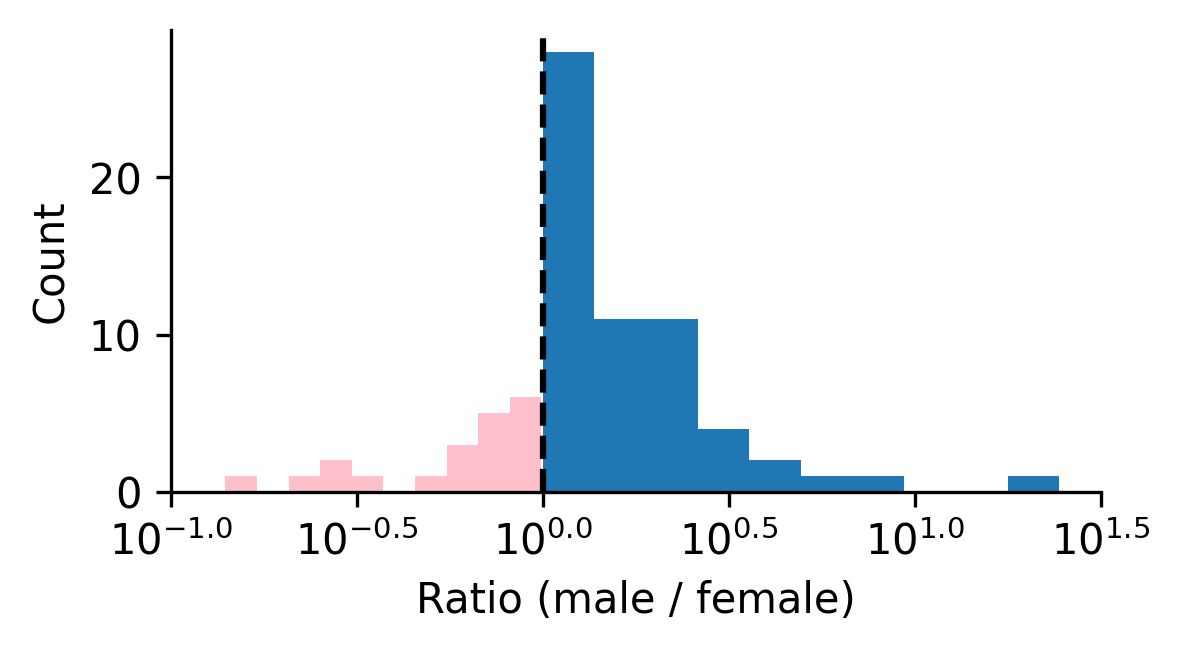

In [5]:
plt.figure(figsize=(4, 2), dpi=300)
r = ratios[~np.isinf(ratios)]
r = r[r > 0]
logr = np.log10(r)
print(
    "mean",
    r.mean().round(2),
    'median',
    np.median(r).round(2),
    "frac>0",
    (r > 1).sum(),
    "/",
    len(r),
    "excluding",
    np.sum(np.isinf(ratios)),
    "all-male studies and",
    np.sum(ratios == 0),
    "all-female studies",
)
plt.hist(logr[logr < 0], color="pink")  # , bins=100)
plt.hist(logr[logr >= 0], color="C0")  # , bins=100)
plt.axvline(0, color="black", ls="--")
ticks = plt.xticks()[0]
plt.xticks(ticks, [f"$10^{{{t}}}$" for t in ticks])
plt.xlabel("Ratio (male / female)")
plt.ylabel("Count")
plt.show()

### Overal study counts

/tmp/ipykernel_3398902/431083353.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(212)


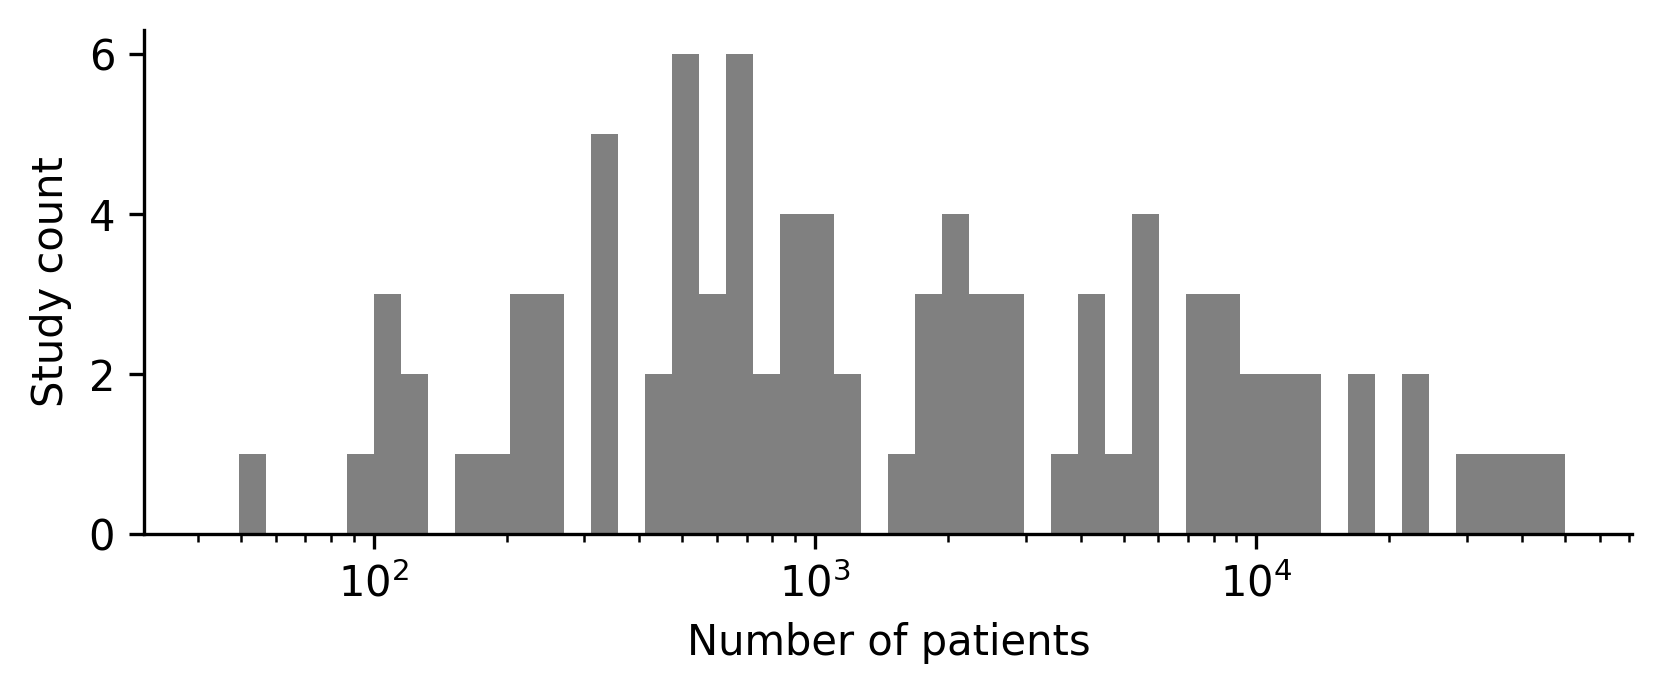

In [6]:
plt.figure(dpi=300)
x = df['num_total_corrected']
x = x[x > 0]
hist, bins, _ = plt.hist(x, bins=50)

# histogram on log scale.
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins, color='gray')
plt.xscale("log")
plt.xlabel('Number of patients')
plt.ylabel('Study count')
plt.show()

### Race ratios

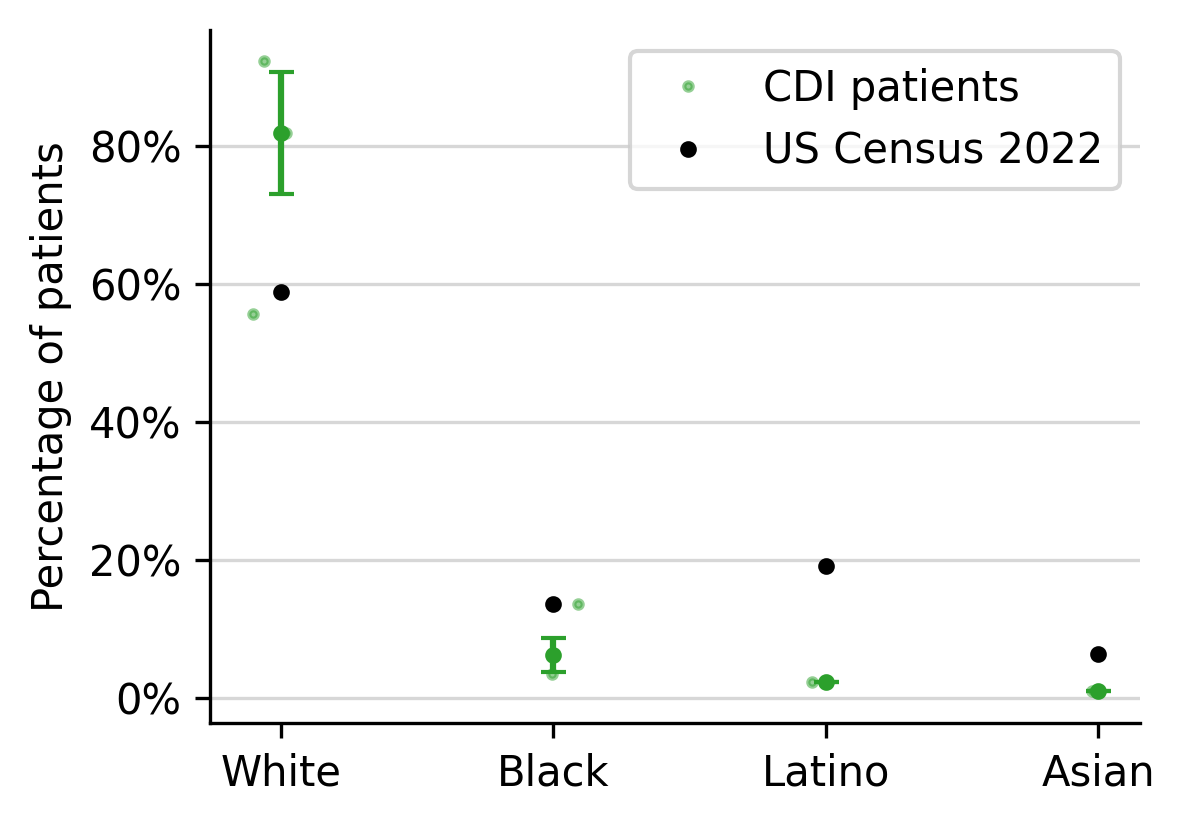

In [46]:
race_keys = ['num_white_corrected',	'num_black_corrected', 'num_latino_corrected', 'num_asian_corrected']
CENSUS_NUMS = {
    'White': 58.9,
    'Black': 13.6,
    'Latino': 19.1,
    'Asian': 6.3,
}
vals_dict = defaultdict(list)
for k in race_keys:
    vals = df[k][df[k].notnull() & ~(df[k] == 'Unk')]
    vals = [float(v[:-1]) for v in vals]
    vals_dict[k] = vals

# make boxplot
plt.figure(figsize=(4, 3), dpi=300)
# plt.boxplot(vals_dict.values(), labels=vals_dict.keys(), showfliers=False)
# add scatterplots
for i, (k, v) in enumerate(vals_dict.items()):
    kwargs = {}
    if i == len(vals_dict) - 1:
        kwargs['label'] = 'CDI patients'

    plt.plot(np.random.normal(i, 0.05, len(v)), v, 'o', alpha=0.5, color='C2', ms=2, **kwargs)
    plt.plot(i, np.median(v), 'o', color='C2', ms=3) #, ms=3)
    plt.errorbar(i, np.median(v), yerr=np.std(v) / np.sqrt(len(v)), color='C2', capsize=3) #, ms=3)

    if i == len(vals_dict) - 1:
        kwargs['label'] = 'US Census 2022'
    # plot census
    val = CENSUS_NUMS[list(CENSUS_NUMS.keys())[i]]
    plt.plot(i, val, 'o', color='black', ms=3, **kwargs) #, ms=3)


plt.legend()
plt.xticks(labels=['White', 'Black', 'Latino', 'Asian'], ticks=range(4))
plt.yticks(ticks=range(0, 100, 20), labels=[f'{t}%' for t in range(0, 100, 20)])
plt.ylabel("Percentage of patients")
plt.grid(axis='y', alpha=0.5)
plt.show()